# EAZY SED Composite Evolution Code

- This code is intended to pull galaxies selected from analysis to be used in the EAZY SED Composite Evolution Code.
    -  we will pull the restframe SEDs of galaxies and do some of the following things.



1. We will first have two seperate seds we choose to look for then read in:
    - The ugr seds (the averages from each redshift range)
    - the UVJ seds (the average sed from each galaxy region)

2. We can then create the composite sets and output the plots of these galaxies

In [328]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath
import seaborn as sns
from scipy.stats import gaussian_kde

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [329]:
# In addition also use astSED to create filters

# Read in all filters
# UVJ Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')
# Spitzer filters
pb_f3_6_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I1.dat')
pb_f4_5_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I2.dat')
pb_f5_8_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I3.dat')
pb_f8_0_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I4.dat')
# ugr filters
pb_u_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.u_SDSS.dat')
pb_g_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.g_SDSS.dat')
pb_r_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.r_SDSS.dat')


# Load all of the filters 
pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)
pb_f3_6 = astSED.Passband(pb_f3_6_path, normalise=False)
pb_f4_5 = astSED.Passband(pb_f4_5_path, normalise=False)
pb_f5_8 = astSED.Passband(pb_f5_8_path, normalise=False)
pb_f8_0 = astSED.Passband(pb_f8_0_path, normalise=False)
pb_u = astSED.Passband(pb_u_path, normalise=False)
pb_g = astSED.Passband(pb_g_path, normalise=False)
pb_r = astSED.Passband(pb_r_path, normalise=False)

filter_set = {'U': pb_U, 'V':pb_V, 'J':pb_J, 'IRAC3.6': pb_f3_6,'IRAC4.5': pb_f4_5,'IRAC5.8': pb_f5_8, 'IRAC8.0':pb_f8_0, 'u': pb_u, 'g': pb_g, 'r':pb_r}



In [330]:
# Using astSED get the wavelength the filters use
pb_U_wavelength = pb_U.effectiveWavelength()

# Do for all filters
pb_V_wavelength = pb_V.effectiveWavelength()
pb_J_wavelength = pb_J.effectiveWavelength()


# now ugr
pb_u_wavelength = pb_u.effectiveWavelength()
pb_g_wavelength = pb_g.effectiveWavelength()
pb_r_wavelength = pb_r.effectiveWavelength()

# Print these
print(f'U: {pb_U_wavelength}')
print(f'V: {pb_V_wavelength}')
print(f'J: {pb_J_wavelength}')
print(f'u: {pb_u_wavelength}')
print(f'g: {pb_g_wavelength}')
print(f'r: {pb_r_wavelength}')


U: 3524.656536727612
V: 5525.060451799561
J: 12393.093155655273
u: 3569.6226123486795
g: 4711.992397306267
r: 6285.945598240396


In [331]:


# Skirtor models
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

# Read in the AGN templates
type1_agn, type1_params = create_type1_skirtor_agn(skirtor_folderpath)
type2_agn, type2_params = create_type2_skirtor_agn(skirtor_folderpath)

# AGN Model
agn_model_name = 'Type1AGN' # 'Type1AGN', 'Type2AGN'


# Choose an AGN model
if agn_model_name == 'Type1AGN':
    agn_model = type1_agn
elif agn_model_name == 'Type2AGN':
    agn_model = type2_agn
else:
    print('AGN model not recognised')

In [332]:
# Readin the two dataframes
uvj_seds = pd.read_csv('outputs\ThesisPlots\ZFOURGE_obsevational_composites_fluxesType1AGN_EAZY_UVJ_galaxies.csv')

# Drop the unnamed column
uvj_seds = uvj_seds.drop(columns='Unnamed: 0')

In [333]:
uvj_seds

,id,z,population
0,COSMOS_1341,1.2650,SF
1,CDFS_18026,0.7203,Quiescent
2,CDFS_18214,0.7346,Dusty


In [334]:
# Read in the ugr data
ugr_seds = pd.read_csv('outputs\ThesisPlots\ZFOURGE_obsevational_composites_fluxesType1AGN_EAZY_ugr_galaxies.csv')

# Drop the unnamed column
ugr_seds = ugr_seds.drop(columns='Unnamed: 0')

In [335]:
ugr_seds

,ID,Redshift,Bin
0,COSMOS_1698,1.2438,z < 2.6
1,UDS_1597,2.9778,2.6 < z < 3.5
2,UDS_15263,3.7467,z > 3.5


In [336]:
# Read in the uvj seds
uvj_sed_dict = {'ID': [], 'SED': []}
# read each sed in the uvj_seds df
for i in range(len(uvj_seds)):
    # Get the galaxy id
    galaxy_id_field = uvj_seds['id'][i].split('_')[0]
    galaxy_id_number =uvj_seds['id'][i].split('_')[1]
    sed_path = f'Eazy Template Extractions\zfourgeSEDs\{galaxy_id_field}\SED_{galaxy_id_field}_{galaxy_id_number}.csv'
    
    df = pd.read_csv(sed_path, skiprows=1, names=['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)'])
    
    # Handle the case of bad values within the sed
    # check for infinities or null values and replace   
    if np.any(np.isnan(df)):
        df = df.replace([np.inf, -np.inf], np.nan)
    if np.any(np.isinf(df) ):
        df = df.replace([np.inf, -np.inf], np.nan)
    
    
    # Whereever there are NaN values, interpolate
    df = df.interpolate()
    
    
    if np.all(df.iloc[:, 1] == 0.0):
        #print("Not including object: ", objname)
        continue
    
    # Convert microns to angstroms    
    df.iloc[:, 0] = df.iloc[:, 0]
    
    # name each of the columns appropriately
    df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)']
    
    
    
    
    
    
    # Add the sed to the dictionary
    uvj_sed_dict['ID'].append(uvj_seds['id'][i])
    uvj_sed_dict['SED'].append(df)




In [337]:
uvj_sed_dict

{'ID': ['COSMOS_1341', 'CDFS_18026', 'CDFS_18214'],
 'SED': [      lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
  0           9.091832e+01                      2.304795e-01
  1           9.391563e+01                      2.313483e-01
  2           9.591383e+01                      2.372062e-01
  3           9.791204e+01                      2.455235e-01
  4           9.991024e+01                      2.582298e-01
  ...                  ...                               ...
  2813        7.992820e+05                      4.105147e-06
  2814        9.991024e+05                      2.527224e-06
  2815        1.198923e+06                      1.746939e-06
  2816        1.398743e+06                      1.288297e-06
  2817        1.598564e+06                      9.894352e-07
  
  [2818 rows x 2 columns],
        lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
  0           9.053000e+01                      2.960512e-03
  1           9.351450e+01                      2.908216e

In [338]:
# Seperate the uvj seds into 
uvj_ids = uvj_seds['id']
uvj_seds_df = uvj_sed_dict['SED']

In [339]:
# Alpha values
alphas = np.linspace(0, 1, 11)


In [340]:
alphas

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [341]:
# Create some composites
composites = generate_composite_set(agn_model, uvj_seds_df, alphas)

In [342]:
composites

[[      lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
  0           9.091832e+01                      2.304795e-01
  1           9.120108e+01                      2.305615e-01
  2           9.391563e+01                      2.313483e-01
  3           9.591383e+01                      2.372062e-01
  4           9.791204e+01                      2.455235e-01
  ...                  ...                               ...
  2915        1.198923e+06                      1.746939e-06
  2916        1.258925e+06                      1.609217e-06
  2917        1.398743e+06                      1.288297e-06
  2918        1.445440e+06                      1.218456e-06
  2919        1.598564e+06                      9.894352e-07
  
  [2920 rows x 2 columns],
        lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
  0           9.053000e+01                      2.960512e-03
  1           9.120108e+01                      2.948753e-03
  2           9.351450e+01                      2.90821

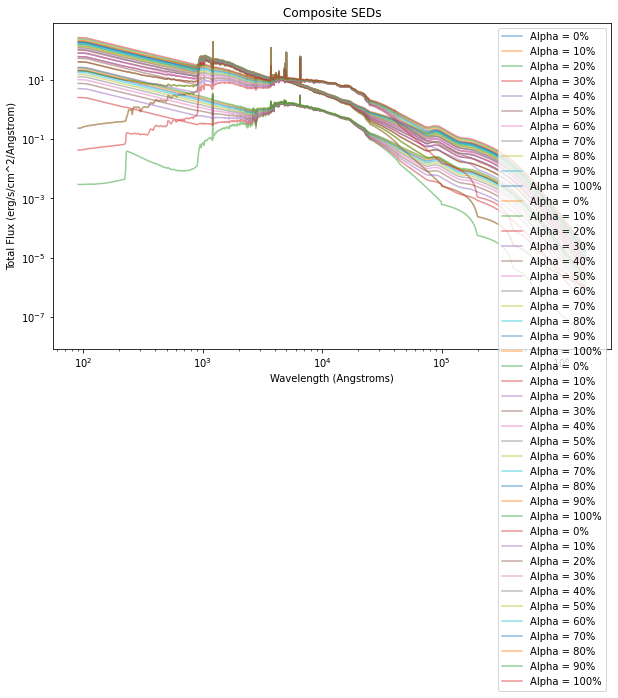

In [343]:
# We can also plot the passbands for the UVJ
U_arr = np.array(pb_U.asList())
V_arr = np.array(pb_V.asList())
J_arr = np.array(pb_J.asList())


# Plot the composites
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Ensure all galaxies were redshifted by their respective redshift
# Plot the composites
for i in range(len(composites)):
    ax.loglog(composites[i][0].iloc[:, 0], composites[i][0].iloc[:, 1], label=f'Alpha = {int(alphas[i] *100)}%', alpha=0.5)
    

for i in range(len(composites)):
    
    
    
    ax.loglog(composites[i][0].iloc[:, 0], composites[i][0].iloc[:, 1], label=f'Alpha = {int(alphas[i] *100)}%', alpha=0.5)
    
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Total Flux (erg/s/cm^2/Angstrom)')
ax.set_title('Composite SEDs')
ax.legend()


for i in range(len(composites)):
    ax.loglog(composites[i][1].iloc[:, 0], composites[i][1].iloc[:, 1], label=f'Alpha = {int(alphas[i] *100)}%', alpha=0.5)

ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Total Flux (erg/s/cm^2/Angstrom)')
ax.set_title('Composite SEDs')
ax.legend()


for i in range(len(composites)):
    ax.loglog(composites[i][2].iloc[:, 0], composites[i][2].iloc[:, 1], label=f'Alpha = {int(alphas[i] *100)}%', alpha=0.5)

ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Total Flux (erg/s/cm^2/Angstrom)')
ax.set_title('Composite SEDs')
ax.legend()
plt.show()

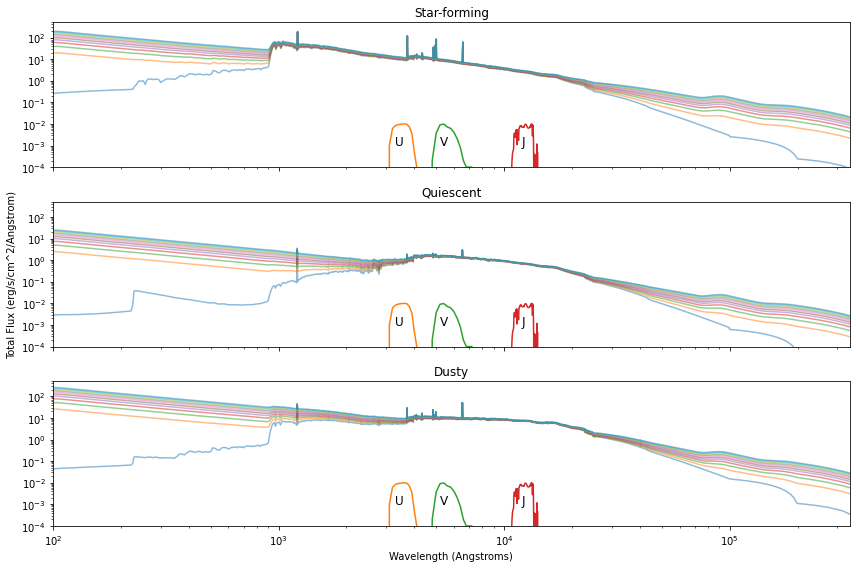

In [344]:
# Now that we know that it works we choose to format a nice plot to reflect this
# simply for the uvj galaxies

# A 3 row by 1 column plot should work
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)

# We want to plot 
# First plot, the star-forming galaxy composite
sc = 1e-2
for i in range(len(composites)):
    ax[0].loglog(composites[i][0].iloc[:, 0], composites[i][0].iloc[:, 1], alpha=0.5)
    ax[1].loglog(composites[i][1].iloc[:, 0], composites[i][1].iloc[:, 1], label=f'Alpha = {int(alphas[i] *100)}%', alpha=0.5)
    ax[2].loglog(composites[i][2].iloc[:, 0], composites[i][2].iloc[:, 1], alpha=0.5)

for j in range(3):
    ax[j].loglog(U_arr[:, 0], sc*U_arr[:,1])
    ax[j].loglog(V_arr[:, 0], sc*V_arr[:,1])
    ax[j].loglog(J_arr[:, 0], sc*J_arr[:,1])
    # Plot the filter letter inside of the passband
    ax[j].text(0.33e4, 1e-3, 'U', fontsize=12)
    ax[j].text(0.52e4, 1e-3, 'V', fontsize=12)
    ax[j].text(1.2e4, 1e-3, 'J', fontsize=12)
    
ax[2].set_xlabel('Wavelength (Angstroms)')
ax[1].set_ylabel('Total Flux (erg/s/cm^2/Angstrom)')
ax[0].set_title('Star-forming')
ax[1].set_title('Quiescent')
ax[2].set_title('Dusty')

# Clip all axis between some limits
for a in ax:
    a.set_xlim(1e2, 340000)
    a.set_ylim(1e-4, 500)

plt.tight_layout()


# # Plot a single figure legend, outside of the plot
# fig.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))

# Save 
plt.savefig('outputs/ThesisPlots/CompositeSEDs_UVJ.png', dpi=300)


plt.show()

In [345]:
# Now we do the same for the ugr space
ugr_sed_dict = {'ID': [], 'SED': []}
# read each sed in the uvj_seds df
for i in range(len(ugr_seds)):
    # Get the galaxy id
    galaxy_id_field = ugr_seds['ID'][i].split('_')[0]
    galaxy_id_number =ugr_seds['ID'][i].split('_')[1]
    sed_path = f'Eazy Template Extractions\zfourgeSEDs\{galaxy_id_field}\SED_{galaxy_id_field}_{galaxy_id_number}.csv'
    
    df = pd.read_csv(sed_path, skiprows=1, names=['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)'])
    
    # Handle the case of bad values within the sed
    # check for infinities or null values and replace   
    if np.any(np.isnan(df)):
        df = df.replace([np.inf, -np.inf], np.nan)
    if np.any(np.isinf(df) ):
        df = df.replace([np.inf, -np.inf], np.nan)
    
    
    # Whereever there are NaN values, interpolate
    df = df.interpolate()
    
    
    if np.all(df.iloc[:, 1] == 0.0):
        #print("Not including object: ", objname)
        continue
    
    # Convert microns to angstroms    
    df.iloc[:, 0] = df.iloc[:, 0]
    
    # name each of the columns appropriately
    df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)']
    
    
    
    
    
    
    # Add the sed to the dictionary
    ugr_sed_dict['ID'].append(ugr_seds['ID'][i])
    ugr_sed_dict['SED'].append(df)

In [346]:
ugr_sed_dict

{'ID': ['COSMOS_1698', 'UDS_1597', 'UDS_15263'],
 'SED': [      lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
  0           9.151728e+01                      3.048570e-02
  1           9.453433e+01                      3.082290e-02
  2           9.654570e+01                      3.145829e-02
  3           9.855707e+01                      3.341554e-02
  4           1.005684e+02                      3.691597e-02
  ...                  ...                               ...
  2813        8.045475e+05                      3.008969e-06
  2814        1.005684e+06                      1.767395e-06
  2815        1.206821e+06                      1.188715e-06
  2816        1.407958e+06                      8.603991e-07
  2817        1.609095e+06                      6.546683e-07
  
  [2818 rows x 2 columns],
        lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
  0           9.277718e+01                      1.306839e-02
  1           9.583576e+01                      1.301919e-02

In [347]:
# split up
ugr_ids = ugr_seds['ID']
ugr_seds_df = ugr_sed_dict['SED']



In [348]:
# Create some composites
composites = generate_composite_set(agn_model, ugr_seds_df, alphas)


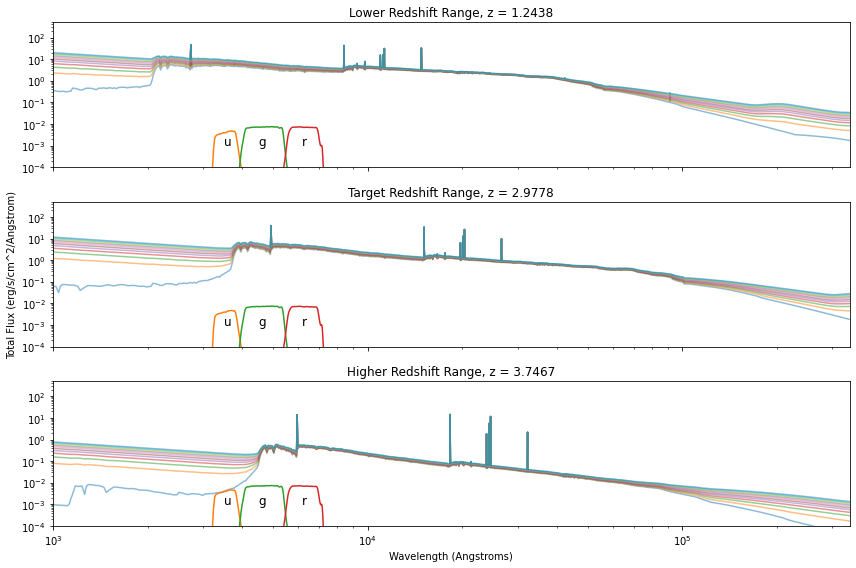

In [349]:
# A 3 row by 1 column plot should work
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)

# get the ugr arrays
u_arr = np.array(pb_u.asList())
g_arr = np.array(pb_g.asList())
r_arr = np.array(pb_r.asList())


# We want to plot
# First plot, the lower redshift galaxies
# Second plot, the target redshift galaxies
# Third plot, the higher redshift galaxies
z_1 = ugr_seds['Redshift'][0]
z_2 = ugr_seds['Redshift'][1]
z_3 = ugr_seds['Redshift'][2]
for i in range(len(composites)):
    
    #redshift the galaxy
    # redshiftfactor
    redshift_factor = (1 + z_1)
    composites[i][0].iloc[:, 0] = composites[i][0].iloc[:, 0] * redshift_factor
    redshift_factor = (1 + z_2)
    composites[i][1].iloc[:, 0] = composites[i][1].iloc[:, 0] * redshift_factor
    redshift_factor = (1 + z_3)
    composites[i][2].iloc[:, 0] = composites[i][2].iloc[:, 0] * redshift_factor
    
    
    ax[0].loglog(composites[i][0].iloc[:, 0], composites[i][0].iloc[:, 1], label=f'Alpha = {int(alphas[i] *100)}%', alpha=0.5)
    ax[1].loglog(composites[i][1].iloc[:, 0], composites[i][1].iloc[:, 1], label=f'Alpha = {int(alphas[i] *100)}%', alpha=0.5)
    ax[2].loglog(composites[i][2].iloc[:, 0], composites[i][2].iloc[:, 1], label=f'Alpha = {int(alphas[i] *100)}%', alpha=0.5)


# 
for j in range(3):
    ax[j].loglog(u_arr[:, 0], sc*u_arr[:,1])
    ax[j].loglog(g_arr[:, 0], sc*g_arr[:,1])
    ax[j].loglog(r_arr[:, 0], sc*r_arr[:,1])
    # Plot the filter letter inside of the passband
    ax[j].text(0.35e4, 1e-3, 'u', fontsize=12)
    ax[j].text(0.45e4, 1e-3, 'g', fontsize=12)
    ax[j].text(0.62e4, 1e-3, 'r', fontsize=12)



ax[2].set_xlabel('Wavelength (Angstroms)')
ax[1].set_ylabel('Total Flux (erg/s/cm^2/Angstrom)')
ax[0].set_title(f'Lower Redshift Range, z = {z_1}')
ax[1].set_title(f'Target Redshift Range, z = {z_2}')
ax[2].set_title(f'Higher Redshift Range, z = {z_3}')




# Scale axis
for a in ax:
    a.set_xlim(1e3, 340000)
    a.set_ylim(1e-4, 500)
    
plt.tight_layout()

# Save
plt.savefig('outputs/ThesisPlots/CompositeSEDs_ugr.png', dpi=300)

plt.show()

